<a href="https://colab.research.google.com/github/rizaho/ml_for_financial_analysis/blob/main/201_1_Introduction_to_Time_Series_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# https://ceb.udemy.com/course/forecasting-python/learn/lecture/45337473#overview

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from google.colab import drive
import seaborn as sns
%matplotlib inline
from copy import copy
from scipy import stats
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
import math
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import month_plot, quarter_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # auto correlation, partial auto-correlation
from statsmodels.tsa.seasonal import seasonal_decompose

# runtime settings
import sys
#np.set_printoptions(threshold=sys.maxsize)

In [3]:
# read data from google drive
drive.mount('/content/drive')
DATA_ROOT_PATH = "Python-Time-Series-Forecasting"
DATA_SUB_INTRO = "Introduction to Time Series Forecasting"
DRIVE_DATASET_PATH = "/content/drive/My Drive/Colab Notebooks/" + DATA_ROOT_PATH + "/" + DATA_SUB_INTRO + "/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df = pd.read_csv(DRIVE_DATASET_PATH + "bitcoin_price.csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


# Time Series Index

In [5]:
# Convert Date column to a datetime object: "%Y-%m-%d" or "YYYY-MM-DD"
df["Date"] = pd.to_datetime(df["Date"], format = "%Y-%m-%d")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [6]:
# set date as index
df.set_index("Date", inplace = True)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [7]:
#select a specific date in dataframe
df.loc["2021-11-09"]

,2021-11-09
Open,6.754973e+04
High,6.853034e+04
Low,6.638206e+04
Close,6.697183e+04
Adj Close,6.697183e+04
Volume,4.235799e+10


In [8]:
# resample the data to a different time granularity
# for example we can get 1 row for each week
df.resample("W").mean()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-21,429.916998,437.718195,406.624402,416.859003,416.859003,3.138068e+07
2014-09-28,410.650718,418.668993,399.377141,407.692566,407.692566,2.668180e+07
2014-10-05,369.774288,376.721000,353.207140,361.426570,361.426570,3.952256e+07
2014-10-12,346.927429,363.308864,337.567858,355.234580,355.234580,4.873611e+07
2014-10-19,389.010284,397.790427,380.410575,390.479854,390.479854,2.241458e+07
...,...,...,...,...,...,...
2023-12-03,38038.414062,38743.479353,37766.444196,38399.994978,38399.994978,1.919430e+10
2023-12-10,43002.227121,44027.167411,42586.383929,43538.877232,43538.877232,2.692909e+10
2023-12-17,42369.368862,42969.940848,41148.103237,42020.472656,42020.472656,2.407050e+10


# Exploratory Data Analysis (EDA)

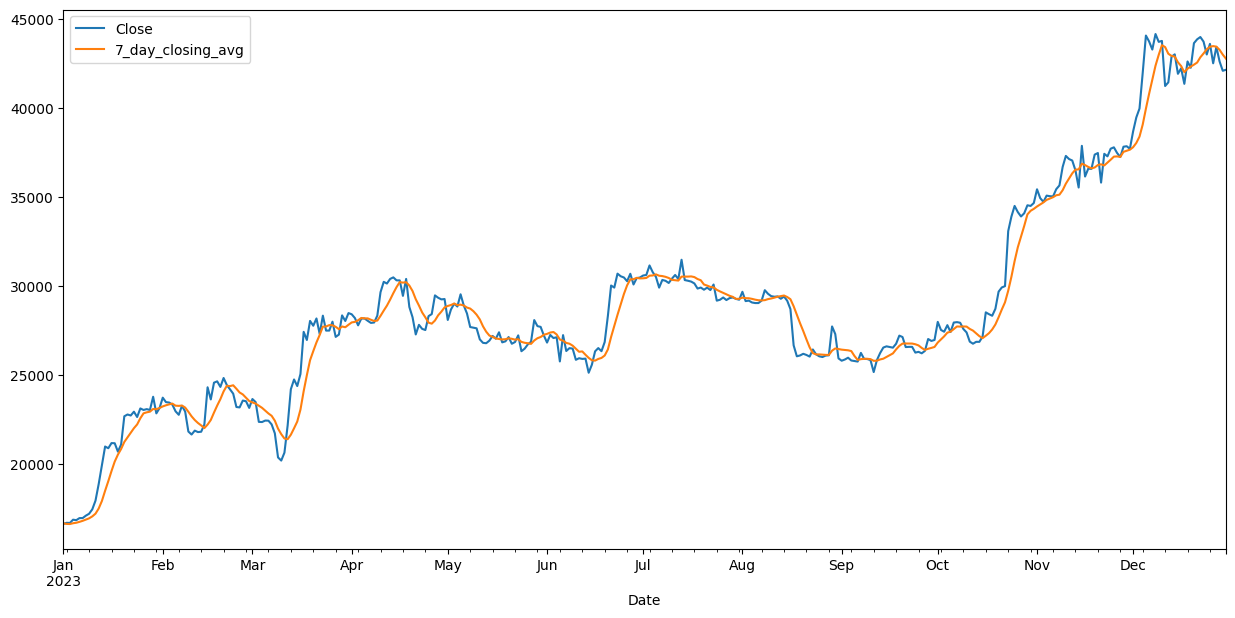

In [9]:
# Generate a 7 day rolling average for the Closing Price
df["7_day_closing_avg"] = df["Close"].rolling(window = 7).mean()
df

# plot the Close Price and the 7 day rolling average
# df[["Close", "7_day_closing_avg"]].plot(figsize = (15, 7)) # all data
df[["Close", "7_day_closing_avg"]].loc["2023"].plot(figsize = (15, 7)) # only for 2023
plt.show()

In [10]:
# find the month with the highest closing average
#df.groupby(df.index.month)["Close"].mean().sort_values(ascending = False)
#df.resample("M")["Close"].mean().sort_values(ascending = False)
df.resample("ME")["Close"].mean().idxmax() # ME: Mounth End

Timestamp('2021-11-30 00:00:00')

In [11]:
# compute the percentage change for the close variable
df["daily_returns_100%"] = df["Close"].pct_change() * 100
df.head()

,Open,High,Low,Close,Adj Close,Volume,7_day_closing_avg,daily_returns_100%
Date,,,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800,NaN,NaN
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200,NaN,-7.192558
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700,NaN,-6.984265
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600,NaN,3.573492
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100,NaN,-2.465854


In [12]:
# which days have more than %10 change
df[abs(df["daily_returns_100%"]) > 10]

,Open,High,Low,Close,Adj Close,Volume,7_day_closing_avg,daily_returns_100%
Date,,,,,,,,
2014-11-12,367.984985,429.717987,367.984985,423.561005,423.561005,45783200,365.519579,15.193570
2015-01-03,314.846008,315.149994,281.082001,281.082001,281.082001,33054400,310.171718,-10.776686
2015-01-13,267.394012,268.277008,219.906006,225.860992,225.860992,72843904,271.743853,-15.659308
2015-01-14,223.893997,223.893997,171.509995,178.102997,178.102997,97638704,255.138994,-21.144862
2015-01-15,176.897003,229.067001,176.897003,209.843994,209.843994,81773504,244.638280,17.821709
...,...,...,...,...,...,...,...,...
2022-09-09,19328.140625,21439.410156,19310.962891,21381.152344,21381.152344,48469528171,19781.450056,10.612188
2022-11-08,20600.671875,20664.607422,17603.544922,18541.271484,18541.271484,118992465607,20409.998326,-10.006132
2022-11-09,18543.761719,18590.458984,15682.692383,15880.780273,15880.780273,102905151606,19798.752093,-14.349022


# Data visualization

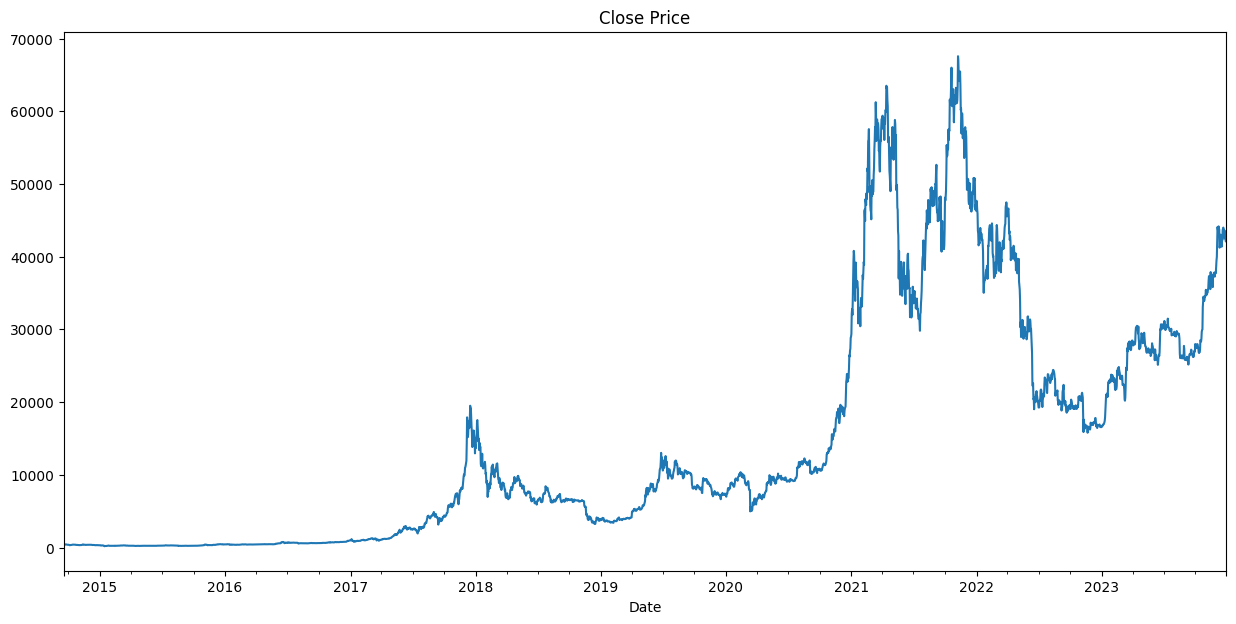

In [13]:
# plot daily closing price
df["Close"].plot(figsize = (15, 7), title= "Close Price")
plt.show()

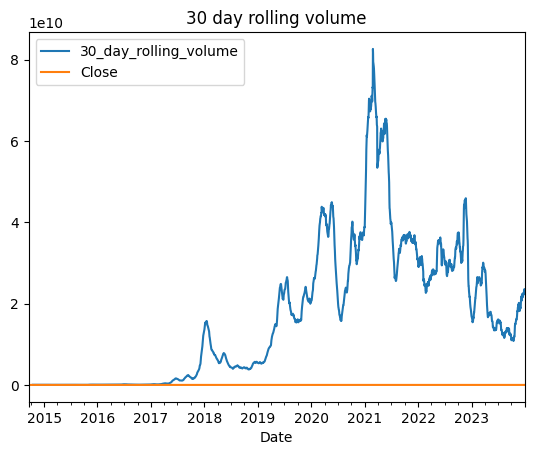

In [14]:
# Create a variable for 30 days rolling average
df["30_day_rolling_volume"] = df["Volume"].rolling(window = 30).mean()

# Plot the Closing Price and the 30 day rolling volumne
# But here magnitutes are very different. Then lets add another axis then.
df[["30_day_rolling_volume", "Close"]].plot(title = "30 day rolling volume")
plt.show ()

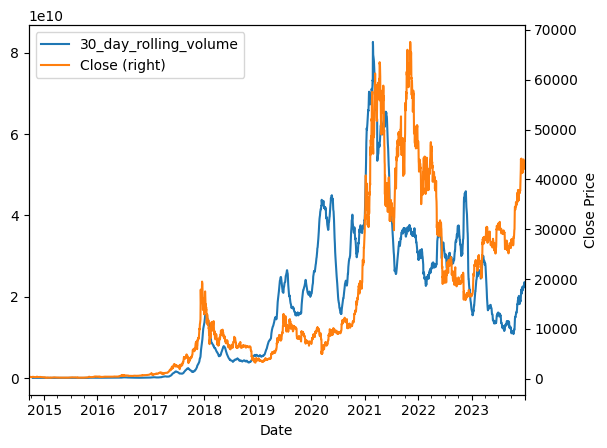

In [15]:
df[["30_day_rolling_volume"]].plot(legend = True)
ax = df["Close"].plot(secondary_y = True, legend = True)
ax.set_ylabel("Close Price")
plt.show()

In [16]:
# Perform correlation between closing price and 30 day rolling volume
print(df["30_day_rolling_volume"].corr(df["Close"]))

# This is called Pearson Correlation which is not ideal for time series data.
# Spearman Correlation fits better
df[["30_day_rolling_volume", "Close"]].corr()

0.750445379618605


,30_day_rolling_volume,Close
30_day_rolling_volume,1.000000,0.750445
Close,0.750445,1.000000


# Data Manipulation

In [18]:
# identify missing values
df.isna().sum()

,0
Open,0
High,0
Low,0
Close,0
Adj Close,0
Volume,0
7_day_closing_avg,6
daily_returns_100%,1
30_day_rolling_volume,29


In [21]:
# fill the missing values
# day 29 is missing, then put day 30 value to day 29.
#df["30_day_rolling_volume"].fillna(method = "bfill", inplace = True) # this gives a warning
df["30_day_rolling_volume"] = df["30_day_rolling_volume"].bfill() # bfill: backward fill, ffill: forward fill


In [23]:
# we can also fill missing values with intrpolation
df["7_day_closing_avg"] = df["7_day_closing_avg"].interpolate(method = "linear")

In [24]:
# fetch the index and generate new variables
df.index

DatetimeIndex(['2014-09-17', '2014-09-18', '2014-09-19', '2014-09-20',
               '2014-09-21', '2014-09-22', '2014-09-23', '2014-09-24',
               '2014-09-25', '2014-09-26',
               ...
               '2023-12-21', '2023-12-22', '2023-12-23', '2023-12-24',
               '2023-12-25', '2023-12-26', '2023-12-27', '2023-12-28',
               '2023-12-29', '2023-12-30'],
              dtype='datetime64[ns]', name='Date', length=3392, freq=None)

In [25]:
df.index.dayofweek

Index([2, 3, 4, 5, 6, 0, 1, 2, 3, 4,
       ...
       3, 4, 5, 6, 0, 1, 2, 3, 4, 5],
      dtype='int32', name='Date', length=3392)

In [26]:
# generate new variables
df["year"] = df.index.year
df["month"] = df.index.month
df["day"] = df.index.day

In [27]:
# feature engineering - Lagged values
df["lag_1"] = df["Close"].shift(1)
df["lag_2"] = df["Close"].shift(2)
df


,Open,High,Low,Close,Adj Close,Volume,7_day_closing_avg,daily_returns_100%,30_day_rolling_volume,year,month,day,lag_1,lag_2
Date,,,,,,,,,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800,NaN,NaN,3.624856e+07,2014,9,17,NaN,NaN
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200,NaN,-7.192558,3.624856e+07,2014,9,18,457.334015,NaN
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700,NaN,-6.984265,3.624856e+07,2014,9,19,424.440002,457.334015
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600,NaN,3.573492,3.624856e+07,2014,9,20,394.795990,424.440002
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100,NaN,-2.465854,3.624856e+07,2014,9,21,408.903992,394.795990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-26,43599.847656,43603.175781,41676.488281,42520.402344,42520.402344,30026850982,43486.929688,-2.505525,2.315280e+10,2023,12,26,43613.140625,43016.117188
2023-12-27,42518.468750,43683.160156,42167.582031,43442.855469,43442.855469,25260941032,43457.016183,2.169436,2.336140e+10,2023,12,27,42520.402344,43613.140625
2023-12-28,43468.199219,43804.781250,42318.550781,42627.855469,42627.855469,22992093014,43279.688058,-1.876028,2.340460e+10,2023,12,28,43442.855469,42520.402344


# Seasonality

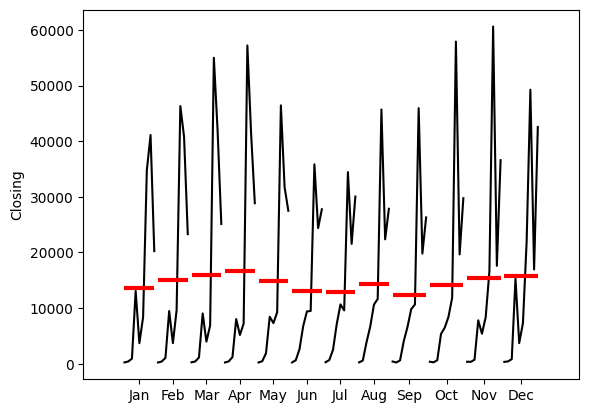

In [34]:
# Montly seasonality
month_plot(df["Close"].resample("ME").mean(),
           ylabel = "Closing") # here we do not see the seasonality much
plt.show()

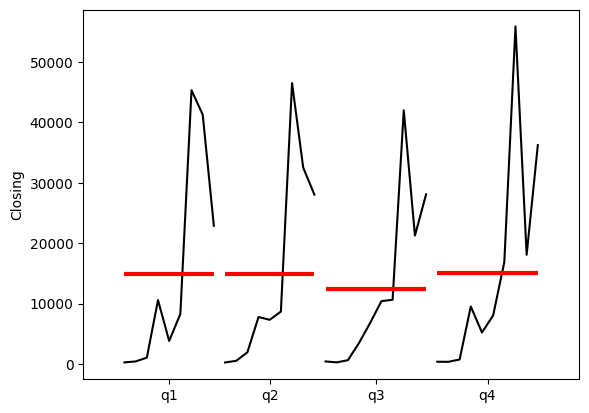

In [36]:
# Quarter plot
quarter_plot(df["Close"].resample("QE").mean(),
             ylabel = "Closing")
plt.show()


In [37]:
# i did not added the choco data set


## Seasonal Decomposition
We will try to analysis trend, seasonality and error (noise, not explaind data)

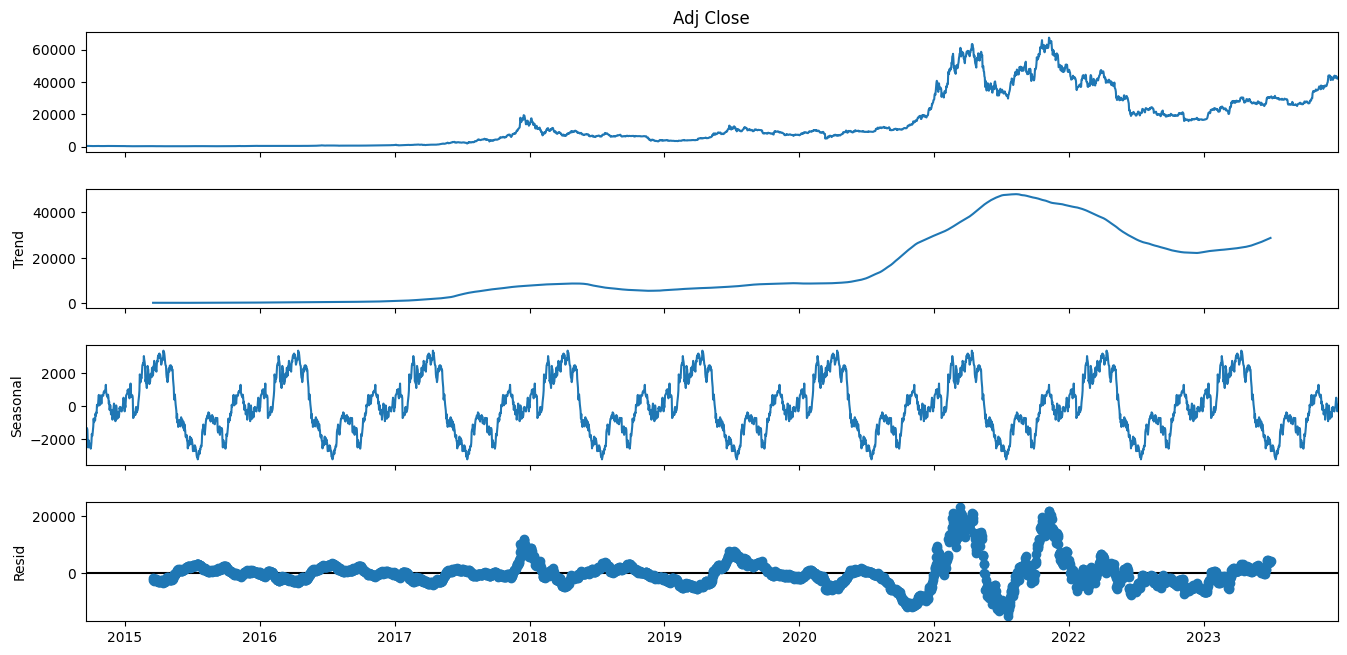

In [45]:
# Seasonal decomposion for df["Adj Close"]
# Seasonal decomposion might be additive (constant change) or multiplicative (percentage).
# NOTE: seasonal_decompose only allows 1 seasonality
#decomposition = seasonal_decompose(df["Close"], model="additive")
decomposition = seasonal_decompose(
    df["Adj Close"],
    model="additive", # multiplicative
    period = 365)

fig = decomposition.plot()
fig.set_size_inches(15, 7)
plt.show()

# Auto-Correlations

*   The Auto-Corrolations finds out if there is information in the past.
*   We compare (correlation) t vs t-n (lagged values)

## Auto-correlation

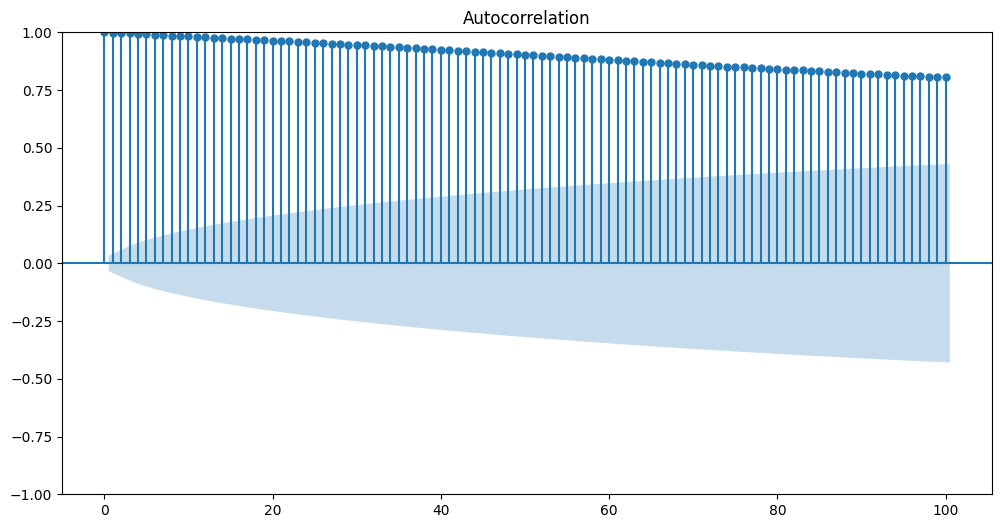

In [50]:
# Plot ACF of the bitcoin Adj Close
fig, ax =  plt.subplots(figsize = (12, 6))
plot_acf(df["Adj Close"], lags = 100, ax = ax)
plt.show()

# Here, it seems there is some correlation between t and t-n but the reason is t-(n-1) is the reason for t-(n-2).
# So we need to remove this effects between t and t-100. Partial auto-correlation will do the trick.

## Partial auto-correlation

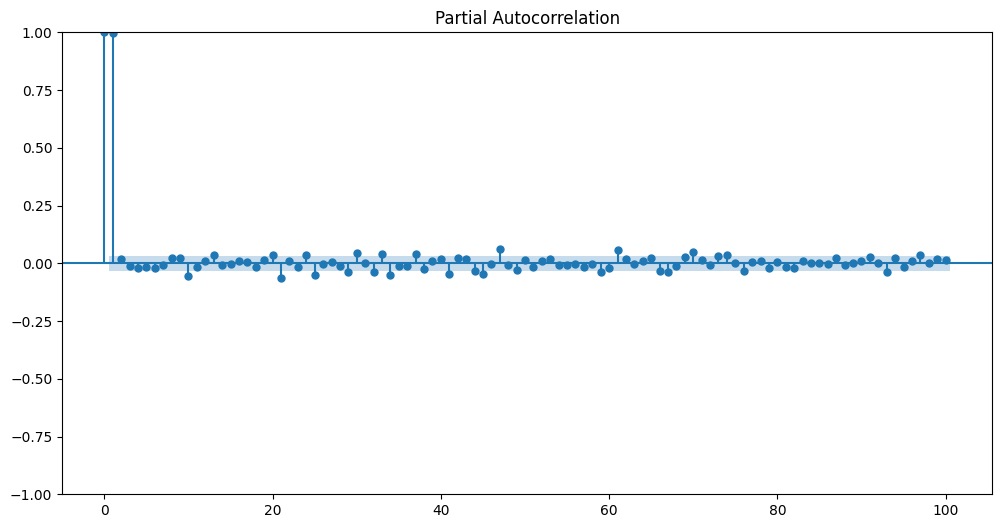

In [51]:
# Plot PACF of the bitcoin Adj Close
fig, ax =  plt.subplots(figsize = (12, 6))
plot_pacf(df["Adj Close"], lags = 100, ax = ax)
plt.show()

# So only the t-1 is correlated to t